# HW11 Assignment II - Cluster time trends in NYC businesses

This notebook presents an analysis of buisness data using time series and clustering. The notebook is based on the PUI 2016 HW 11 II notebook by fedhere. The main work on this notebook instance was:

1. get and prep the data (Download and consolidate from the census site / nycprepared)

2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

4. Use another clustering algorithm (of your choice)

5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

6. Compare the results of the 2 algorithms

7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

In [538]:
# Imports to work with with statistical analysis, maps, etc.

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import ast
from cStringIO import StringIO
import os
import json
import requests
import urllib2
import urllib
import shapely
import zipfile
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import geopy
from geopy.distance import great_circle
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp
# Using the last development version of geopandas at this time
# pip install git+git://github.com/geopandas/geopandas.git
from geopandas import GeoDataFrame

from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)
pl.rcParams['font.size']=12

In [11]:
# Download the files and move them to PUIDATA

path = os.getenv('PUIDATA')+'/'

#!for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#!for ((y=0; y<=1; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=2; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#!for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done

# !mv *.zip $PUIDATA

In [12]:
# Veryfy that the files are there
#!ls $PUIDATA

In [492]:
# Create a new dataframe to consolidate all the buissnes information from the census
zips = np.arange(10001,11697)
dfZips = pd.DataFrame(zips, columns=['zip'])

for i in np.arange(94,100):
    dfBiz = pd.DataFrame()
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df['year'] = int('19'+ set)
    df = df[['zip','est','year']][(df.zip >= 10001) & (df.zip <= 11697)]
    for index, row in df.iterrows():
        dfBiz.loc[index,'zip']=row['zip']
        dfBiz.loc[index,str(int('19'+ set))]=row['est']
    dfBiz.zip = dfBiz.zip.astype(int)
    dfZips = pd.merge(dfZips, dfBiz, on='zip')
        
for i in np.arange(0,15):
    dfBiz = pd.DataFrame()
    if i < 10:
        set = '0' + str(i)
    else:
        set = str(i)
    fname = "zbp" + set + "totals.zip"
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = map(str.lower, df.columns)
    df['year'] = int('20'+ set)
    df = df[['zip','est','year']][(df.zip >= 10001) & (df.zip <= 11697)]
    for index, row in df.iterrows():
        dfBiz.loc[index,'zip']=row['zip']
        dfBiz.loc[index,str(int('20'+ set))]=row['est']
    dfZips = pd.merge(dfZips, dfBiz, on='zip')

dfZips = dfZips.set_index('zip')
dfZips['mean'] = dfZips.mean(axis=1)
dfZips['std'] = dfZips.std(axis=1)

In [494]:
# Normalize each time series by subtract the series mean from each column and dividing by
# the series standard deviation

normed = dfZips

for yr in range(1994, 2015):
    col = str(yr)
    normed[col] = (normed[col] - normed['mean']) / normed['std']

# Remove everything that is not part of the time series
normed.drop(["mean", "std"], axis=1, inplace=True)

In [498]:
# Download the geojson file from git (the original datasource is unrelaiable, we will use the copy)
url = ('https://raw.githubusercontent.com/fedhere/PUI2016_fb55/' +
       'master/HW11_fb55/nyc-zip-code-tabulation-areas-polygons.geojson')

os.system("curl -o nyc-zip-code-tabulation-areas-polygons.geojson " + url)
os.system("mv nyc-zip-code-tabulation-areas-polygons.geojson " + os.getenv("PUIDATA"))

0

In [499]:
# Load the geojson file into a geodataframe
geoZips = GeoDataFrame.from_file( os.getenv("PUIDATA") + '/nyc-zip-code-tabulation-areas-polygons.geojson')
geoZips.rename(columns={'postalCode': 'zip'}, inplace=True)
geoZips = geoZips[['PO_NAME', 'STATE', 'Shape_Area',
                     'Shape_Leng', 'borough', 'geometry','zip']]
len(geoZips)
geoZips.head()

,PO_NAME,STATE,Shape_Area,Shape_Leng,borough,geometry,zip
0,Jackson Heights,NY,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,NY,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,NY,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Bellerose,NY,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Fresh Meadows,NY,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [516]:
# Create a column on the normed dataframe to be able to merge

new_normed = normed.copy()
new_normed['zip'] = new_normed.index
new_normed.zip = new_normed.zip.astype(str)
geoZips.zip = geoZips.zip.astype(str)
normedMerge = pd.merge(geoZips, new_normed, on=['zip'])

In [518]:
normedMerge.index = normedMerge.zip

In [536]:
# Eliminate columns for PCA analysis
normedMerge.drop(['PO_NAME','STATE','Shape_Area','Shape_Leng','borough','geometry','zip'],
                 axis=1, inplace=True)

In [520]:
normedMerge.head()

,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
zip,,,,,,,,,,,,,,,,,,,,,
11372,-1.691274,-1.646775,-1.290781,-1.182711,-0.915716,-0.756790,-0.547008,-0.553365,-0.203728,0.164980,...,0.279407,0.203122,0.317549,0.273050,0.489189,0.851540,0.965967,1.455458,1.677955,1.735168
11004,-0.998602,-1.278833,-1.839295,-1.092012,-0.998602,-1.372243,-1.232128,-0.531550,-0.064498,0.589375,...,0.449260,0.495965,1.056427,0.542670,0.822901,0.636080,0.309144,1.196543,1.196543,1.616890
11040,-0.120966,-0.239809,-1.413390,-1.279691,-1.279691,-1.190558,-1.190558,-1.324257,-0.477496,-0.403219,...,0.161288,0.354408,0.859494,1.082325,0.666373,0.948626,0.859494,1.186313,1.617121,1.542844
11426,3.291619,-0.455224,-0.805396,-1.190586,-1.015499,-0.525258,-0.665327,-0.525258,-0.875431,-0.735362,...,-0.210103,-0.210103,-0.140069,-0.210103,0.175086,0.560276,0.840413,1.190586,0.910448,0.980482
11365,-1.365486,-1.587345,-1.490282,-0.949502,-1.129762,-0.991100,-0.519651,-0.228461,-0.228461,-0.117532,...,0.187523,0.242988,0.367783,0.353917,0.520311,0.728303,1.199753,1.227485,1.712800,1.948525


In [521]:
# PCA Reference
# https://www.codementor.io/python/tutorial/data-science-python-pandas-r-dimensionality-reduction

# Before clustering, we want to be able to represent each zip code in a two dimensional space.
# In our dataset, each zip has 21 different variables, each one corresponding to a year
# These variables represent not just the total counts of businesses in the 1994-2014 range 
# but also all the variation in the time series and relationships within zips in a given year. 
# By using PCA we will be able to reduce these 18 variables to just the two of them that best captures that information.

# In order to do so, we will first how to perform PCA and plot the first two PCs

pca = PCA(n_components = 2)

Xproj = pca.fit_transform(normedMerge)
Xproj_df = pd.DataFrame(Xproj)
Xproj_df.index = normedMerge.index
Xproj_df.columns = ['PC1','PC2']
Xproj_df.head()

print(pca.explained_variance_ratio_) 
Xproj_df.head()

[ 0.5700565   0.15717646]


,PC1,PC2
zip,,
11372,-1.694363,-0.398184
11004,-1.509762,-0.654670
11040,-1.515040,1.286411
11426,0.883632,3.237254
11365,-1.715796,-0.081429


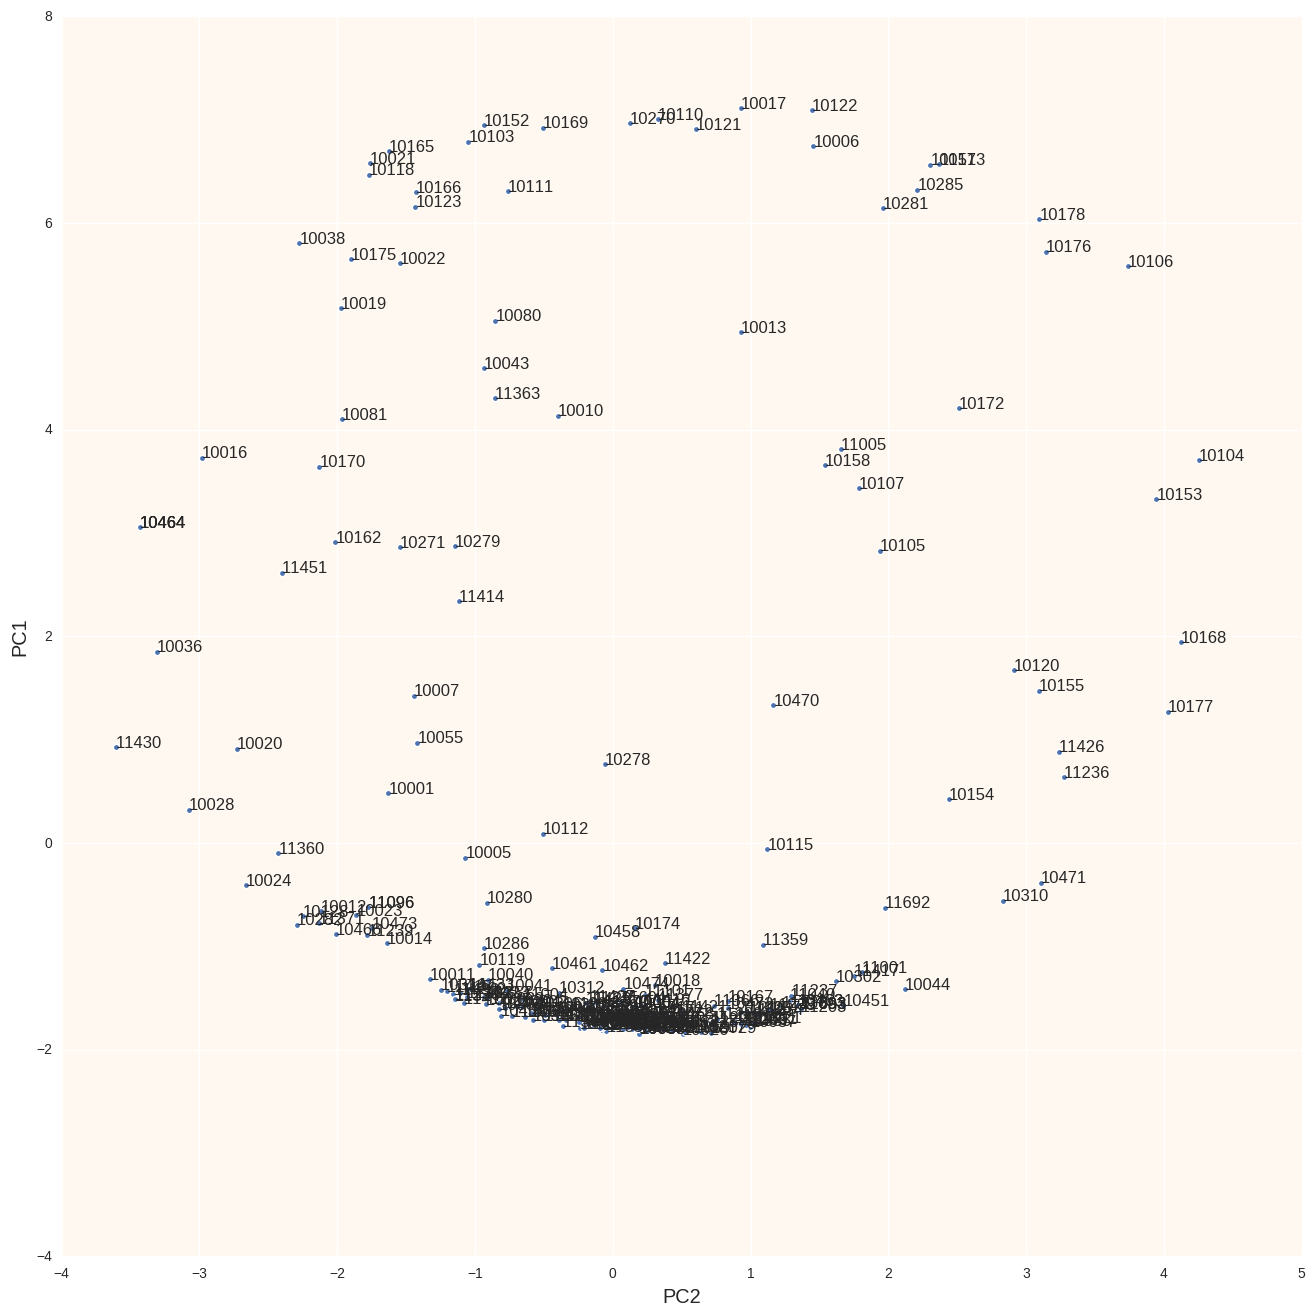

In [522]:
# Plotting the Zipcodes using their Principal Components as the x and y values

ax = Xproj_df.plot(kind='scatter', x='PC2', y='PC1', figsize=(16,16))
for i, country in enumerate(Xproj_df.index):
    ax.annotate(
        country, 
        (Xproj_df.iloc[i].PC2, Xproj_df.iloc[i].PC1)
    )

                Figure I. Plot of the PCA based two dimensional reduction of the census business data time series

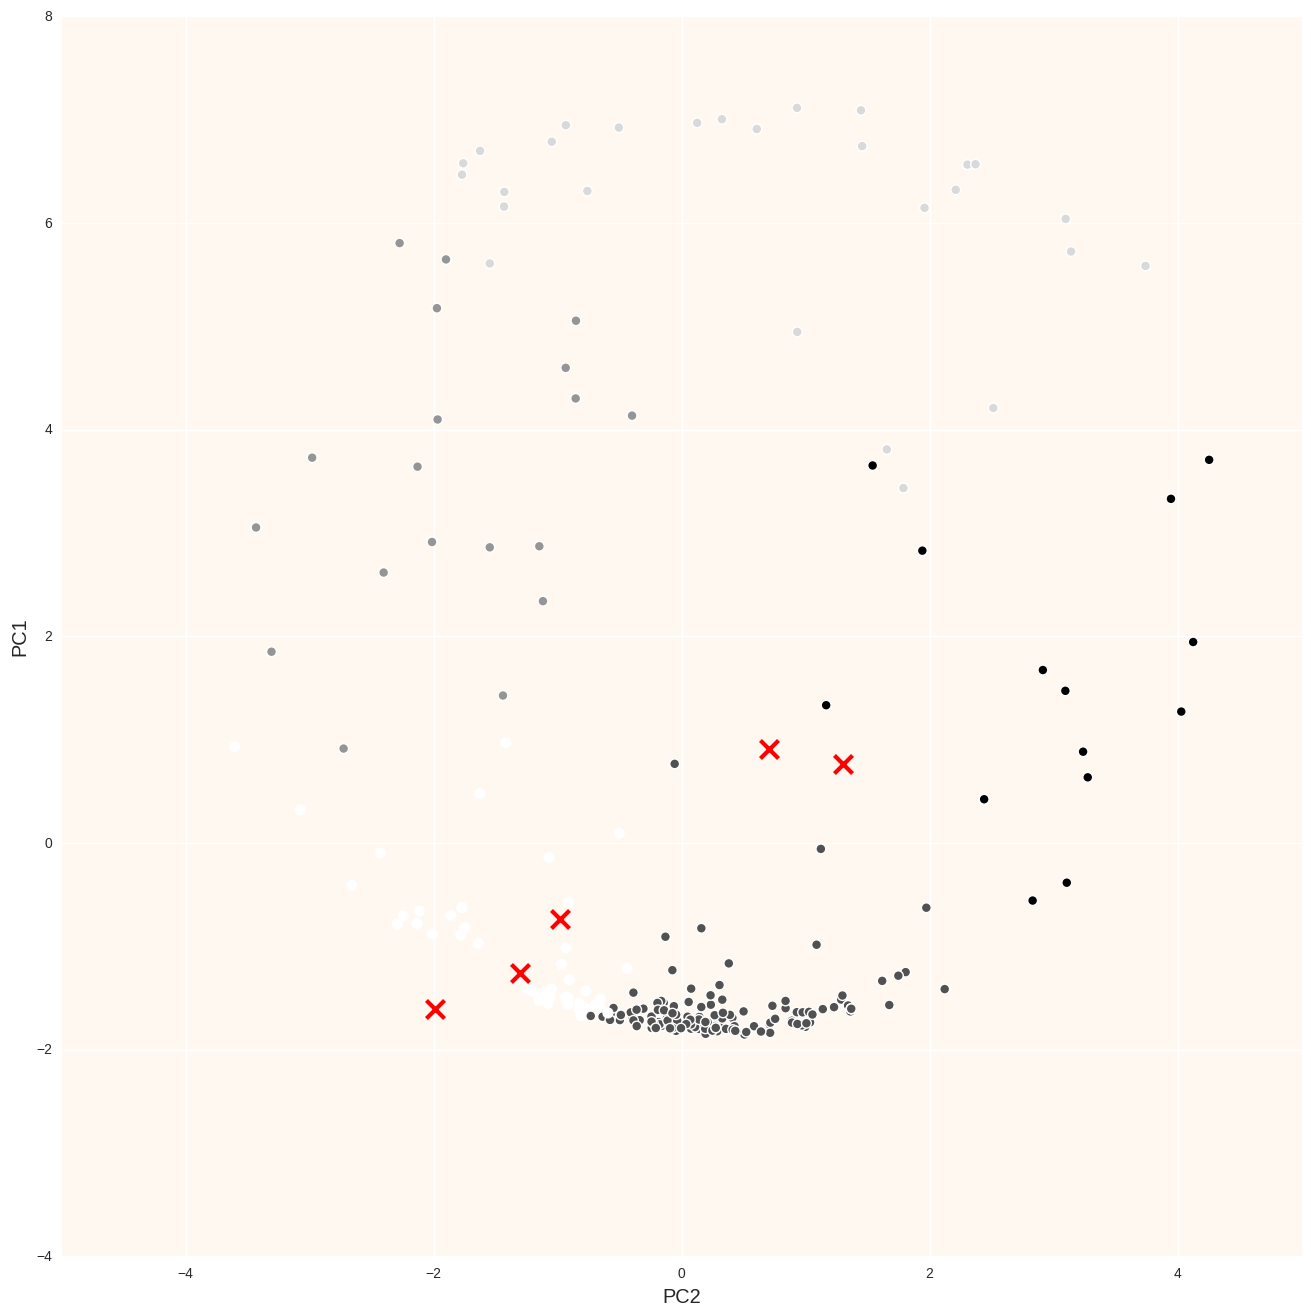

In [524]:
# K-Means Clustering

kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit(normedMerge)

Xproj_df['cluster'] = pd.Series(clusters.labels_, index=Xproj_df.index)

Xproj_df.plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=Xproj_df.cluster.astype(np.float)*10, 
        figsize=(16,16),
        s = 50)

centroids = clusters.cluster_centers_
pl.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)


    Figure II. Plot considering After the K-Means Clustering, each color represent a different cluster, and the X represents the centroids of the clusters.

In [526]:
# Create a column on the normed dataframe to be able to merge
normedMerge['zip'] = normedMerge.index
Xproj_df['zip'] = Xproj_df.index

In [527]:
# Convert the zipcode to an string before the merge
normedMerge.zip = normedMerge.zip.astype(str)
Xproj_df.zip = Xproj_df.zip.astype(str)

In [528]:
normedMerge = pd.merge(geoZips, Xproj_df, on=['zip'])

In [529]:
normedMerge.head()

,PO_NAME,STATE,Shape_Area,Shape_Leng,borough,geometry,zip,PC1,PC2,cluster
0,Jackson Heights,NY,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.694363,-0.398184,3
1,Glen Oaks,NY,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-1.509762,-0.654670,0
2,New Hyde Park,NY,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-1.515040,1.286411,3
3,Bellerose,NY,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,0.883632,3.237254,4
4,Fresh Meadows,NY,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.715796,-0.081429,3


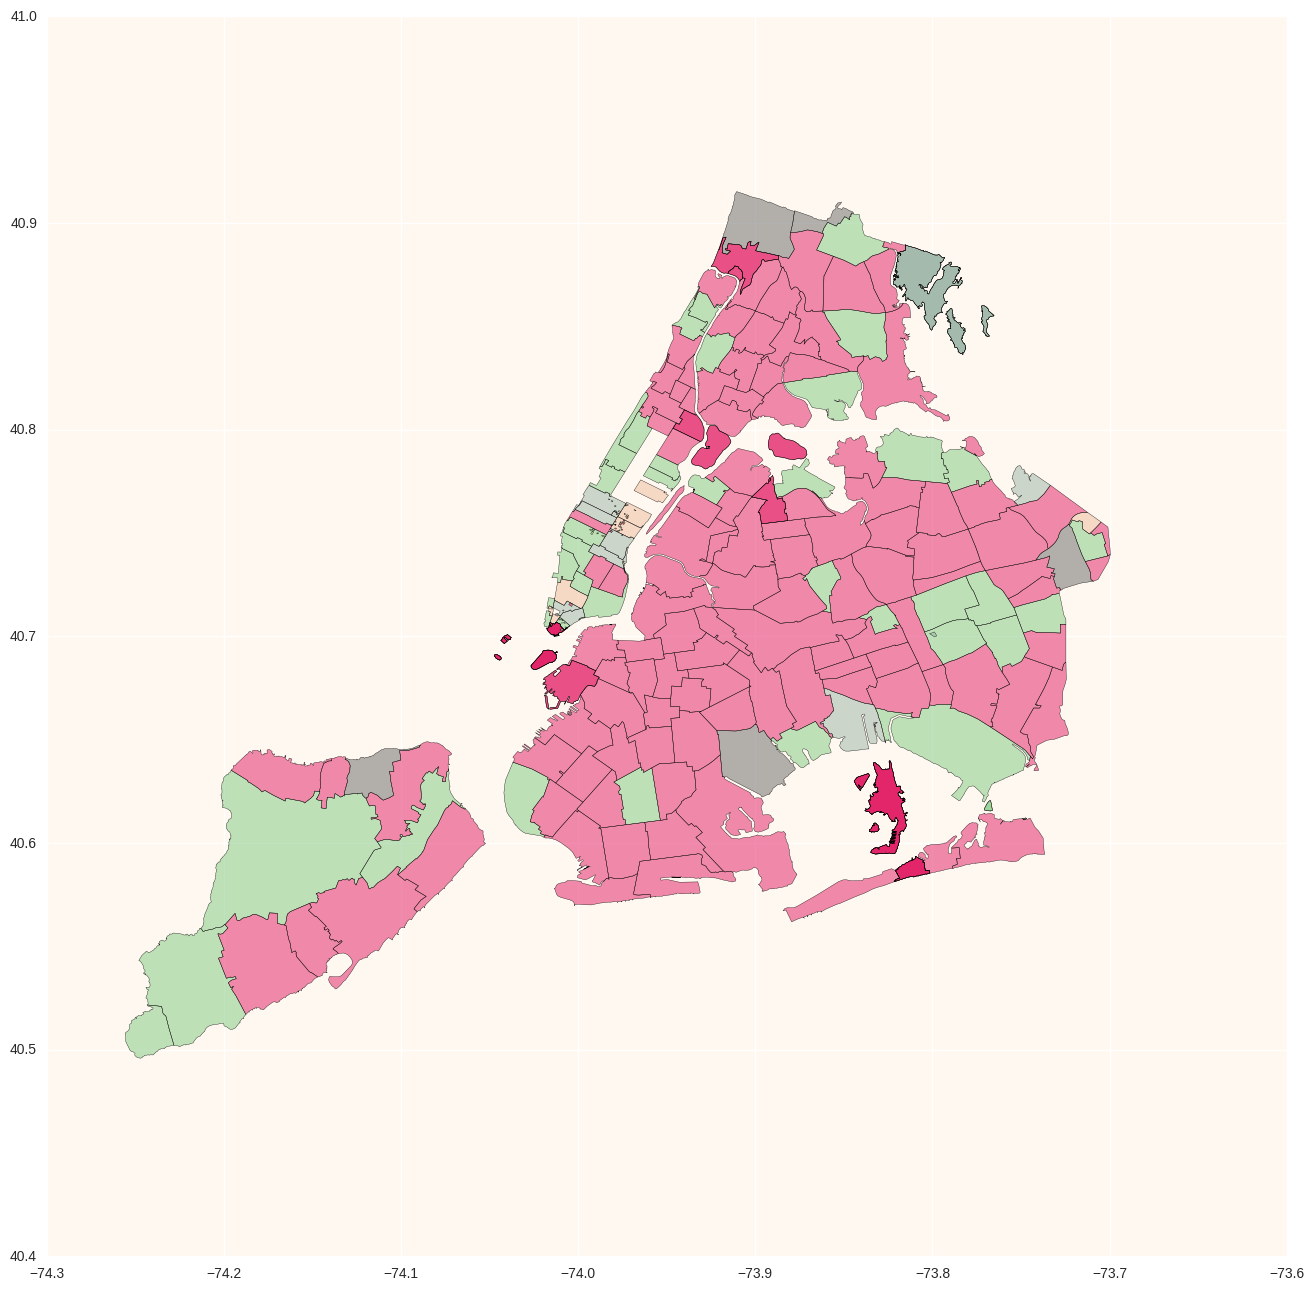

In [535]:
fig, (ax) = pl.subplots(nrows=1, ncols=1, figsize=(16, 16))
normedMerge.plot(column='cluster', cmap='Accent', linewidth=0.25, ax=ax)

            Figure III. New York City Color Map, similar colors represent zipcodes on the same cluster.

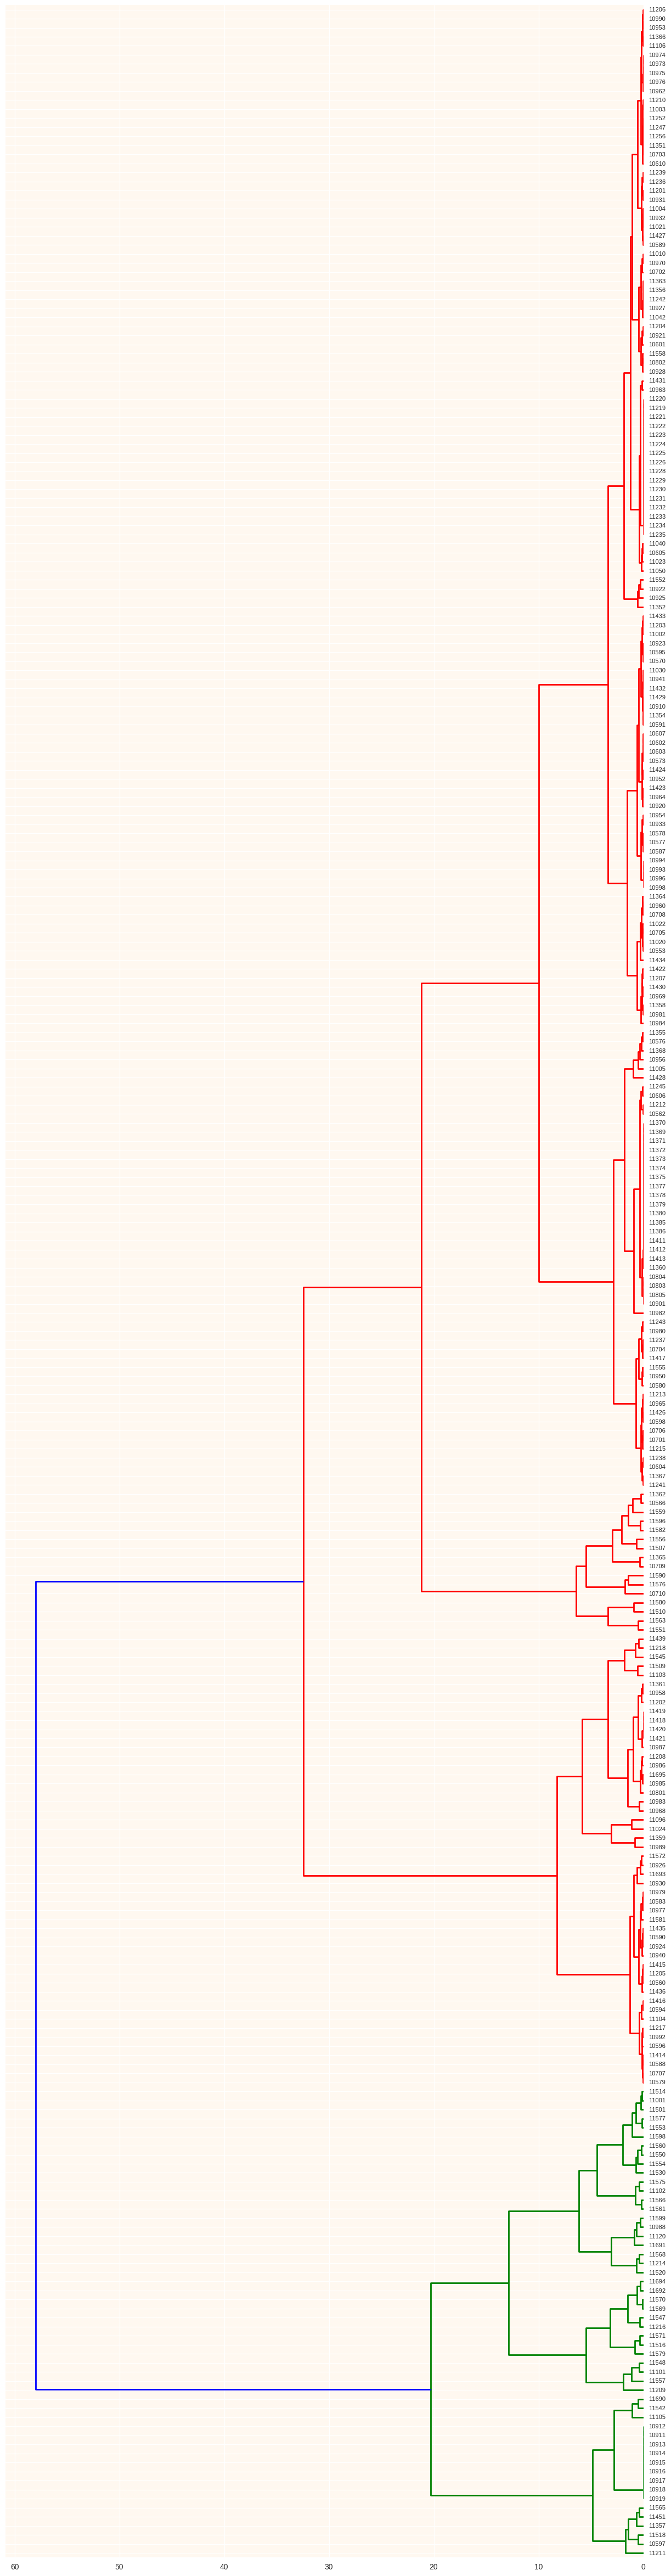

In [550]:
# Using an alternate method to cluster the time series: hierarchical clustering (creation of dendogram)

fig = pl.figure(figsize=(15, 60))
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(normedMerge, method='ward'), labels=normed.index,
                               orientation='left', leaf_font_size=8)

     Figure IV - This figure presents a dendogram of the time series for buisiness by Zip codes.